## 图像区域剔除

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
import time

from main import original_matrix, masked_matrix

#图像路径
image_path = "4kpic1.jpg"  
original_image = Image.open(image_path).convert('L') # 原始灰度图像
image_matrix = np.array(original_image, dtype=float) # 原始灰度矩阵
print('Ready')
# 随机抹去图像数据 默认90%
def mask_image(image, mask_ratio=0.9):
    """
    随机抹去图像数据（用 NaN 表示）。
    输入：
        image: 原始灰度图像矩阵
        mask_ratio: 抹去的像素比例
    输出：
        masked_image: 带有缺失值的图像矩阵
        mask: 掩码矩阵
    """
    mask = np.random.choice([0, 1], size=image.shape, p=[mask_ratio, 1 - mask_ratio])
    masked_image = np.where(mask, image, np.nan)
    return masked_image, mask

# 随机剔除90%像素
masked_image, mask = mask_image(image_matrix, mask_ratio=0.9)
print(f"Mask stats - Known pixels: {np.sum(mask)}, Missing pixels: {np.prod(mask.shape) - np.sum(mask)}")
# 改进初始化
def improved_fill_nan(image):
    filled = image.copy()
    nan_indices = np.where(np.isnan(filled))
    filled[nan_indices] = np.random.normal(np.nanmean(filled), np.nanstd(filled))
    return filled

masked_image = improved_fill_nan(masked_image)
print("Initial masked_image stats:")
print(f"Min: {np.nanmin(masked_image)}, Max: {np.nanmax(masked_image)}")
print(f"NaN count: {np.sum(np.isnan(masked_image))}")

Ready
Mask stats - Known pixels: 827913, Missing pixels: 7466487
Initial masked_image stats:
Min: 1.0, Max: 255.0
NaN count: 0


### SVD矩阵补全



In [2]:
import torch
import time

def approximate_svd(A, k=20, device='cpu'):
    """
    使用截断 SVD（Truncated SVD）对矩阵进行近似分解。
    输入：
        A: 矩阵 (m x n)
        k: 前 k 个奇异值
    输出：
        U, S, V: 近似的 SVD 分解结果
    """
    # 将矩阵移动到指定的设备
    #A = torch.tensor(A, device=device, dtype=torch.float32)
    A = A.clone().detach().to(device).float()
    # 使用 torch 进行 SVD 分解
    U, S, VT = torch.linalg.svd(A, full_matrices=False)

    # 截断，选择前 k 个奇异值及对应的奇异向量
    U = U[:, :k]
    S = torch.diag(S[:k])
    VT = VT[:k, :]

    return U, S, VT

def fill_missing_values_large(image, mask, k=20, max_iter=50, tol=1e-6, diff_buffer=[], device='cpu'):
    # 将图像和掩码移动到设备
    image = torch.tensor(image, device=device, dtype=torch.float32)
    mask = torch.tensor(mask, device=device, dtype=torch.float32)

    # 初始化填充图像
    filled_image = image.clone()
    mean_value = torch.nanmean(filled_image)
    filled_image[torch.isnan(filled_image)] = mean_value  # 初始填充 NaN

    prev_image = filled_image.clone()

    for iteration in range(max_iter):
        # 近似 SVD 分解
        U, S, VT = approximate_svd(filled_image, k=k, device=device)

        # 重构矩阵
        reconstructed_image = U @ S @ VT

        # 更新缺失部分
        filled_image = mask * image + (1 - mask) * reconstructed_image

        # 确保无 NaN 残留
        filled_image[torch.isnan(filled_image)] = mean_value

        # 检查收敛性
        diff = torch.norm(filled_image - prev_image, 'fro') / torch.norm(prev_image, 'fro')
        diff_buffer.append(diff.item())
        if torch.isnan(diff):
            print(f"Iteration {iteration}: Convergence diff is NaN. Exiting early.")
            break

        print(f"Iteration {iteration}: Convergence diff={diff.item()}")
        if diff < tol:
            print(f"Converged in {iteration + 1} iterations.")
            break

        prev_image = filled_image.clone()

    return filled_image.cpu().numpy()

# 近似SVD矩阵补全,并计算运行时间
svd_convergence_buffer=[]
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

start_svd = time.time()
restored_image_svd = fill_missing_values_large(masked_image, mask, k=50, max_iter=2000, tol=1e-4, diff_buffer=svd_convergence_buffer, device=device)
time_svd = time.time() - start_svd

print(f"Completed in {time_svd:.2f} seconds")


/var/folders/cy/3gqr29_s3kqfy02b4rds1v_80000gn/T/ipykernel_33769/217385419.py:17: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  U, S, VT = torch.linalg.svd(A, full_matrices=False)


Iteration 0: Convergence diff=0.11183194816112518
Iteration 1: Convergence diff=0.08457546681165695
Iteration 2: Convergence diff=0.06604748964309692
Iteration 3: Convergence diff=0.05297654867172241
Iteration 4: Convergence diff=0.04346735030412674
Iteration 5: Convergence diff=0.036365609616041183
Iteration 6: Convergence diff=0.030940717086195946
Iteration 7: Convergence diff=0.026713961735367775
Iteration 8: Convergence diff=0.02336241491138935
Iteration 9: Convergence diff=0.020662851631641388
Iteration 10: Convergence diff=0.01845765858888626
Iteration 11: Convergence diff=0.016633043065667152
Iteration 12: Convergence diff=0.015105238184332848
Iteration 13: Convergence diff=0.013812879100441933
Iteration 14: Convergence diff=0.01270830538123846
Iteration 15: Convergence diff=0.011756477877497673
Iteration 16: Convergence diff=0.010929168201982975
Iteration 17: Convergence diff=0.010205027647316456
Iteration 18: Convergence diff=0.009567143395543098
Iteration 19: Convergence diff

In [4]:
def approximate_svd(A, k=20):
    """
    使用截断 SVD（Truncated SVD）对矩阵进行近似分解。
    输入：
        A: 矩阵 (m x n)
        k: 前 k 个奇异值
    输出：
        U, S, V: 近似的 SVD 分解结果
    """
    U, S, VT = svds(A, k=k)
    # 按降序排列奇异值和对应分量
    U = U[:, ::-1]
    S = S[::-1]
    VT = VT[::-1, :]
    return U, np.diag(S), VT

def fill_missing_values_large(image, mask, k=20, max_iter=50, tol=1e-6, diff_buffer=[]):
    filled_image = image.copy()
    mean_value = np.nanmean(filled_image)
    filled_image[np.isnan(filled_image)] = mean_value  # 初始填充 NaN

    prev_image = filled_image.copy()

    for iteration in range(max_iter):
        # 检查矩阵有效性
        if not np.isfinite(filled_image).all():
            print(f"Iteration {iteration}: Detected NaN or Inf in filled_image!")
            print("Debug info: filled_image stats")
            print(f"Min: {np.nanmin(filled_image)}, Max: {np.nanmax(filled_image)}")
            print(f"Mean: {np.nanmean(filled_image)}")
            raise ValueError("Matrix contains NaN or Inf!")

        # 近似 SVD 分解
        U, S, VT = approximate_svd(filled_image, k=k)

        # 重构矩阵
        reconstructed_image = U @ S @ VT

        # 更新缺失部分
        filled_image = mask * image + (1 - mask) * reconstructed_image

        # 确保无 NaN 残留
        filled_image[np.isnan(filled_image)] = mean_value

        # 检查收敛性
        diff = np.linalg.norm(filled_image - prev_image) / np.linalg.norm(prev_image)
        diff_buffer.append(diff)
        if np.isnan(diff):
            print(f"Iteration {iteration}: Convergence diff is NaN. Exiting early.")
            break

        print(f"Iteration {iteration}: Convergence diff={diff}")
        if diff < tol:
            print(f"Converged in {iteration + 1} iterations.")
            break

        prev_image = filled_image.copy()

    return filled_image

# 近似SVD矩阵补全,并计算运行时间
svd_convergence_buffer=[]
start_svd = time.time()
# iter=138, tol=1e-3 time=3min54s
# 经过测试当前maxiter=1000时 diff=diff=0.00018214179407369206
# 如果希望tol计算到1e-4，那么至少需要设置maxiter到1k5或者2k，此外，是否需要调整其他参数 如k，或者考虑更改算子或者其他并行方法
# tol=1e-4 iteration=1281 diff=diff=9.99853999170871e-05 time=36min32s
restored_image_svd = fill_missing_values_large(masked_image, mask, k=50, max_iter=2000, tol=1e-4,diff_buffer=svd_convergence_buffer)
time_svd = time.time() - start_svd




Mask stats - Known pixels: 830053, Missing pixels: 7464347
Initial masked_image stats:
Min: 0.0, Max: 255.0
NaN count: 0


### 交替方向乘子法（ADMM）


In [5]:
import torch

def admm_matrix_completion(M, mask, lambda_param=1.0, rho=1.0, max_iter=100, tol=1e-4, device='cpu', diff_buffer=[]):
    """
    使用 ADMM 实现矩阵补全
    参数:
        M: 输入矩阵（稀疏或稠密，np.nan 表示缺失部分）
        mask: 掩码矩阵（稀疏或稠密，1 表示已知值，0 表示未知值）
        lambda_param: 正则化参数（核范数的权重）
        rho: ADMM 的惩罚系数
        max_iter: 最大迭代次数
        tol: 收敛判定阈值
        device: 'cpu' 或 'mps'，选择设备（CPU 或 GPU）
    返回:
        补全后的矩阵
    """
    # 将 M 和 mask 转为 PyTorch 张量
    M = torch.tensor(M, dtype=torch.float32, device=device)
    mask = torch.tensor(mask, dtype=torch.float32, device=device)
    
    # 初始化变量
    X = initialize_missing_values(M, mask, device)  # 初始矩阵填充
    Z = X.clone()  # 辅助变量
    U = torch.zeros_like(X, device=device)  # 拉格朗日乘子变量

    print('start iter')
    for iter_num in range(max_iter):
        # 更新 X：根据掩码填充已知值
        X[mask.bool()] = M[mask.bool()]
        X[~mask.bool()] = (rho * (Z - U))[~mask.bool()] / (1 + rho)

        # 更新 Z：奇异值软阈值化
        U_plus_X = X + U
        U_svd, S, VT = torch.linalg.svd(U_plus_X, full_matrices=False)   # 使用SVD分解
        # 确保 Z 的维度与 X 一致
        # 保持奇异值阈值化，并确保 S 是正确的维度
        S_threshold = torch.maximum(S - lambda_param / rho, torch.tensor(0.0, device=device))  # 奇异值软阈值化
        # S_threshold 是一个向量，进行矩阵运算时需要匹配维度
        
        # 这里生成 Z 矩阵，确保维度匹配
        Z = torch.matmul(U_svd, torch.diag_embed(S_threshold)) @ VT

        # 更新 U：拉格朗日乘子
        U = U + X - Z

        # 收敛性检查
        diff = torch.norm(X - Z, 'fro') / (torch.norm(X, 'fro') + 1e-8)
        diff_buffer.append(diff.item())
        print(iter_num, diff.item())

        if diff < tol:
            print(f"Converged in {iter_num + 1} iterations.")
            break
        if torch.isnan(diff):
            print(f"Iteration {iter_num}: Convergence diff is NaN. Exiting early.")
            break

    return X.cpu().numpy()  # 返回 numpy 格式的结果

def initialize_missing_values(M, mask, device='cpu'):
    """
    填充矩阵中的缺失值
    参数:
        M: 输入矩阵（稀疏或稠密）
        mask: 掩码矩阵（同样可以是稀疏或稠密）
    返回:
        填充后的矩阵（PyTorch 张量）
    """
    filled_matrix = M.clone()
    # 使用已知部分的均值填充缺失值
    filled_matrix[~mask.bool()] = torch.nanmean(M[mask.bool()])
    return filled_matrix

admm_convergence_buffer=[]
start_admm = time.time()
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
restored_image_admm = admm_matrix_completion(masked_image, mask, lambda_param=0.1, rho=1.0, max_iter=100, tol=5.25e-6, device=device, diff_buffer=admm_convergence_buffer)
time_admm = time.time() - start_admm


start iter
0 3.0660499760415405e-05
1 3.066902718273923e-05
2 2.759847484412603e-05
3 1.5610148693667725e-05
4 9.721433343656827e-06
5 9.118687557929661e-06
6 7.753796126053203e-06
7 6.051658601791132e-06
8 6.641053914790973e-06
9 6.348946953949053e-06
10 9.525495443085674e-06
11 6.047180249879602e-06
12 5.6153980949602555e-06
13 5.93368531554006e-06
14 5.5979107855819166e-06
15 8.740117664274294e-06
16 1.4577123693015892e-05
17 7.332972927542869e-06
18 6.228037818800658e-06
19 5.696491825801786e-06
20 5.410596713772975e-06
21 5.342723397916416e-06
22 5.2541909099090844e-06
23 5.246311502560275e-06
Converged in 24 iterations.


### 指标计算与结果可视化

SVD Method:
Time: 1706.59 seconds
SVD Frobenius Error: 0.2056639305571048
SVD RMSE: 27.60924374870543
ADMM Method:
Time: 28.01 seconds
ADMM Frobenius Error: 0.9487099240095332
ADMM RMSE: 127.35905351933387


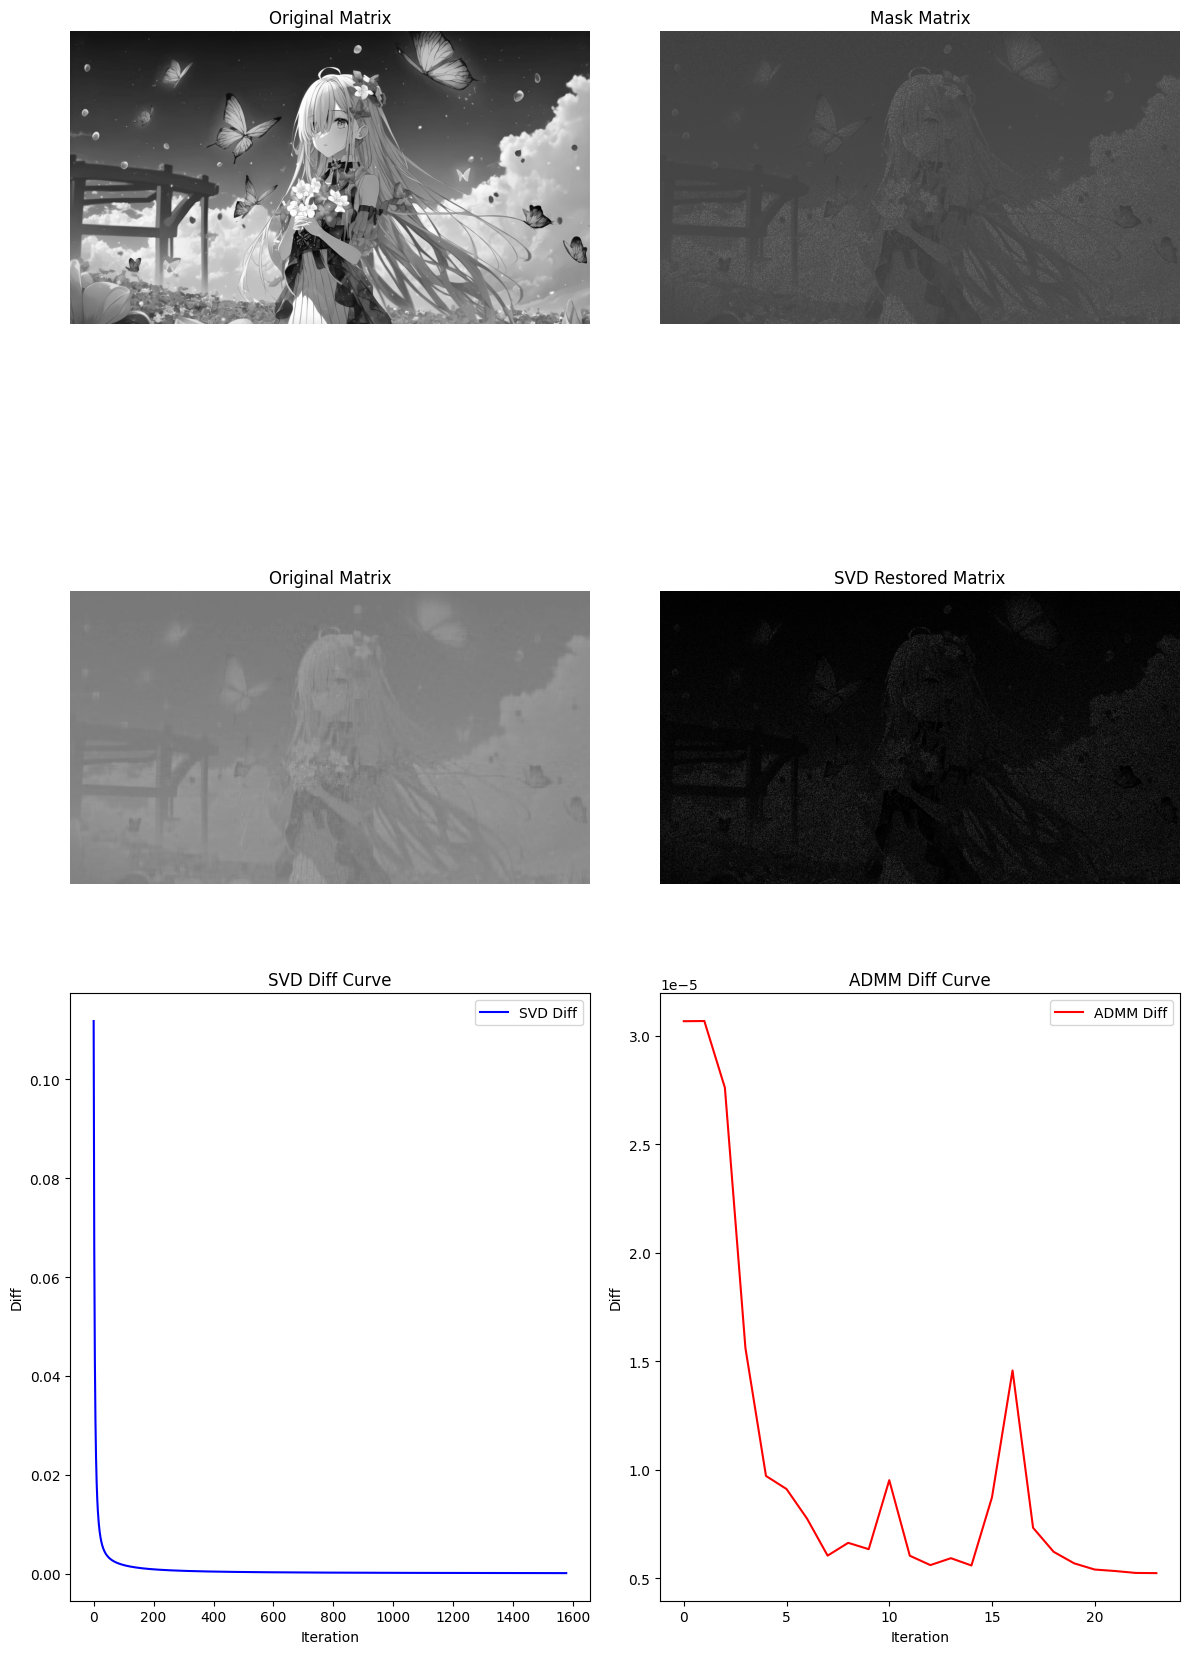

In [23]:
def calculate_rmse(original_matrix, restored_matrix):
    # 将 NaN 值替换为 0
    mask = np.isnan(original_matrix)
    original_matrix = np.nan_to_num(original_matrix, nan=0.0)
    restored_matrix = np.nan_to_num(restored_matrix, nan=0.0)
    
    # 计算 RMSE
    rmse = np.sqrt(np.mean((original_matrix - restored_matrix) ** 2))
    return rmse

def calculate_frobenius_error(original_matrix, restored_matrix):
    # 计算 Frobenius 范数的误差
    error = np.linalg.norm(original_matrix - restored_matrix, 'fro') / np.linalg.norm(original_matrix, 'fro')
    return error

error_svd_f=calculate_frobenius_error(image_matrix,restored_image_svd)
rmse_svd=calculate_rmse(image_matrix,restored_image_svd)
print("SVD Method:")
print(f"Time: {time_svd:.2f} seconds")
print(f"SVD Frobenius Error: {error_svd_f}")
print(f"SVD RMSE: {rmse_svd}")

error_admm_f=calculate_frobenius_error(image_matrix,restored_image_admm)
rmse_admm=calculate_rmse(image_matrix,restored_image_admm)
print("ADMM Method:")
print(f"Time: {time_admm:.2f} seconds")
print(f"ADMM Frobenius Error: {error_admm_f}")
print(f"ADMM RMSE: {rmse_admm}")




def plot_results(original_matrix, masked_image, restored_matrix_svd, restored_matrix_admm, svd_diff, admm_diff):
    # 创建一个3x2的子图
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))

    # 第一行，第一个子图：原始矩阵
    ax = axes[0, 0]
    ax.imshow(original_matrix, cmap='gray')
    ax.set_title("Original Matrix")
    ax.axis('off')

    # 第一行，第二个子图：遮照
    ax = axes[0, 1]
    ax.imshow(np.nan_to_num(masked_image), cmap="gray")
    ax.set_title("Mask Matrix")
    ax.axis('off')
    
    # 第二行，第一个子图：SVD
    ax = axes[1, 0]
    ax.imshow(restored_matrix_svd, cmap='gray')
    ax.set_title("Original Matrix")
    ax.axis('off')

    # 第二行，第二个子图：ADMM
    ax = axes[1, 1]
    ax.imshow(restored_matrix_admm, cmap="gray")
    ax.set_title("SVD Restored Matrix")
    ax.axis('off')

    # 第三行，第一个子图：SVD恢复的diff曲线
    ax = axes[2, 0]
    ax.plot(svd_diff, label="SVD Diff", color='b')
    ax.set_title("SVD Diff Curve")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Diff")
    ax.legend()

    # 第三行，第二个子图：ADMM恢复的diff曲线
    ax = axes[2, 1]
    ax.plot(admm_diff, label="ADMM Diff", color='r')
    ax.set_title("ADMM Diff Curve")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Diff")
    ax.legend()

    # 调整布局
    plt.tight_layout()
    plt.savefig('ans.svg')
    plt.show()

plot_results(image_matrix,masked_image, restored_image_svd, restored_image_admm, svd_convergence_buffer, admm_convergence_buffer)



# # 结果可视化
# plt.figure(figsize=(15, 10))
# plt.subplot(1, 3, 1)
# plt.title("Original Image")
# plt.imshow(image_matrix, cmap="gray")
# plt.axis("off")
# 
# plt.subplot(1, 3, 2)
# plt.title("Masked Image")
# plt.imshow(np.nan_to_num(masked_image), cmap="gray")
# plt.axis("off")
# 
# plt.subplot(1, 4, 3)
# plt.title("Restored Image (SVD)")
# plt.imshow(restored_image_svd, cmap="gray")
# plt.axis("off")
# 
# plt.subplot(1, 4, 4)
# plt.title("Restored Image (ADMM)")
# plt.imshow(restored_image_admm, cmap="gray")
# plt.axis("off")
# 
# plt.tight_layout()
# plt.show()